In [1]:
# Install these libraries before continuing
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

In [3]:
# Changing all columns to doubles to be able to combine the 4 dataframes

cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,2
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


In [4]:
tidy_heart_data <- heart_data_combined |>
                mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Correcting scaling of heart disease data (num)
                filter(chol != 0) |> # There is one incorrect point where chol = 0
                mutate(num = as_factor(num))
tidy_heart_data|>arrange(thalach)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
58,1,4,132,458,1,0,69,0,1,3,NA,NA,0
67,1,4,120,237,0,0,71,0,1,2,0,3,1
55,1,4,172,260,0,0,73,0,2,NA,NA,NA,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,1,3,NA,284,0,0,NA,NA,NA,NA,NA,NA,1
62,1,1,NA,139,0,1,NA,NA,NA,NA,NA,NA,0
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0


In [5]:
# Remove observations with NA values for predictor variables (age, chol, trestbps, thalach, oldpeak) only
heart_data <- tidy_heart_data |>
                filter( !is.na(chol), !is.na(thalach), !is.na(fbs),!is.na(trestbps))
heart_data|>group_by(trestbps)|>
summarize(n=n())
# arrange(oldpeak)

# heart_data

trestbps,n
<dbl>,<int>
92,1
94,2
96,1
⋮,⋮
190,2
192,1
200,2


In [6]:
# Split data into training (80%) and testing (20%) data
set.seed(1234)

#
# clean_heart <- heart_data |>
#                     select(age, chol, trestbps, thalach, oldpeak, num)

clean_heart <- heart_data |>
                    select( num,  exang, fbs, thalach, chol,cp,trestbps)

heart_split <- initial_split(clean_heart, prop = 0.80, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train|>arrange(fbs)
heart_test

num,exang,fbs,thalach,chol,cp,trestbps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,187,250,3,130
0,0,0,178,236,2,120
0,1,0,163,354,4,120
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1,1,108,254,4,160
1,1,1,128,300,4,144
1,0,1,154,333,4,127


num,exang,fbs,thalach,chol,cp,trestbps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,1,150,233,1,145
0,0,0,172,204,2,130
1,1,1,155,203,4,140
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,1,1,151,254,3,134
1,1,0,138,170,4,158
1,0,1,100,223,4,122


### Preliminary Analysis

In [7]:
### Preliminary Analysis Section Here ###

### KNN Classification

In [8]:
# Recipe (standardization)
set.seed(1234)
heart_recipe <- recipe(num ~ ., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Define model specification - tune neighbors using 5-fold cross validation
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vals <- tibble(neighbors = seq(from = 1, to = 40))
# vals <- tibble(neighbors = seq(from = 1, to = 100))
# this takes a bit too long to run on my machine, we can do this in the end 
heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

# TODO: maybe revisit grid = 10 later and explore other k values
heart_accuracy <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(neighbors)

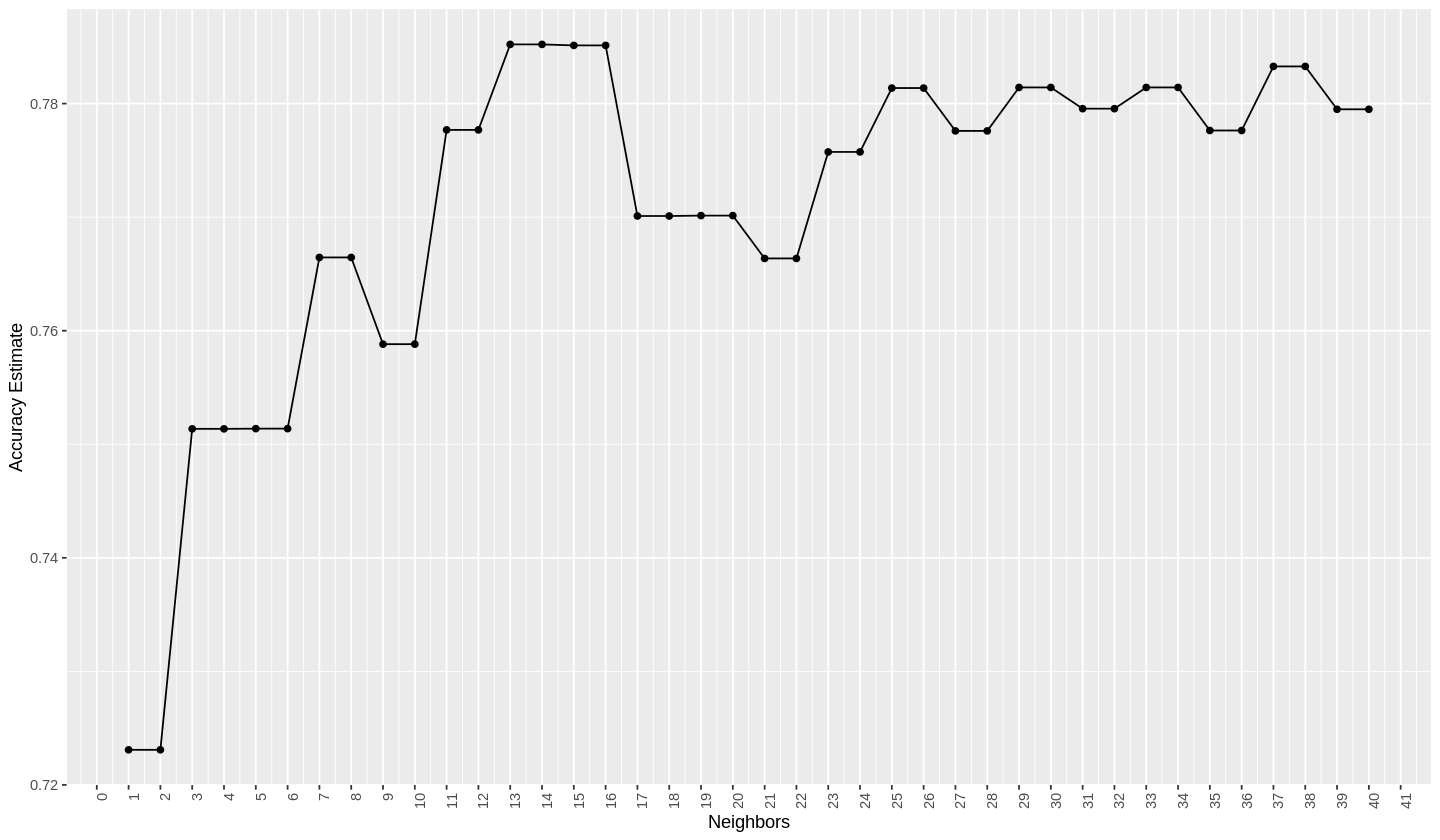

In [9]:
# Generate graph of accuracy
options(repr.plot.width = 12)
k_accuracies <- ggplot(heart_accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 100, by = 1)) +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))

k_accuracies

In [10]:
# Determine best k

best_k <- heart_accuracy |>
            arrange(-mean) |>
            slice(1) |>
            select(neighbors) |>
            pull()

best_k

best_train_accuracy=heart_accuracy|>
    summarize(accuracy=max(mean))|>
    pull()

best_train_accuracy

[1] 13

[1] 0.7852137

In [11]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_resample_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train)
heart_resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.220339
Best kernel: rectangular
Best k: 13

In [12]:
### next steps are to            -test on a new observation
##                               -measure how well the model performs using TRAINING data

In [13]:
heart_test_resample_predict = predict(heart_resample_fit, heart_test)|>
    bind_cols(heart_test)
# prediction of the training data
# heart_train_resample_predict
heart_test_accuracy <- metrics(data=heart_test_resample_predict, truth=num, estimate=.pred_class)|>
    filter(.metric=="accuracy")|>
    pull()
heart_test_accuracy
# options(repr.plot.width = 8, repr.plot.height = 7)

[1] 0.7761194